In [20]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
if torch.cuda.is_available():
    import torch.cuda as t
else:
    import torch as t
from torch import nn, optim
from torch.autograd import Variable
from IPython.display import Audio
from scipy.io import wavfile

class One_Hot(nn.Module):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = t.sparse.torch.eye(depth)
    def forward(self, X_in):
        return Variable(self.ones.index_select(0,X_in.data))
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

## Wavenet  class
Two generation functions are included. generate_slow( ) is easy to understand, but generate( ) is much faster.

In [24]:
class WaveNet(nn.Module):
    def __init__(self, mu=256,n_residue=32, n_skip= 512, dilation_depth=10, n_repeat=5):
        # mu: audio quantization size
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.dilation_depth = dilation_depth
        dilations = self.dilations = [2**i for i in range(dilation_depth)] * n_repeat
        self.one_hot = One_Hot(mu)
        self.from_input = nn.Conv1d(in_channels=mu, out_channels=n_residue, kernel_size=1)
        self.conv_sigmoid = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.conv_tanh = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.skip_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_skip, kernel_size=1)
                         for d in dilations])
        self.residue_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=1)
                         for d in dilations])
        self.conv_post_1 = nn.Conv1d(in_channels=n_skip, out_channels=n_skip, kernel_size=1)
        self.conv_post_2 = nn.Conv1d(in_channels=n_skip, out_channels=mu, kernel_size=1)
        
    def forward(self, input):
        output = self.preprocess(input)
        output = output
        skip_connections = [] # save for generation purposes
        for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
            output, skip = self.residue_forward(output, s, t, skip_scale, residue_scale)
            skip_connections.append(skip)
        # sum up skip connections
        output = sum([s[:,:,-output.size(2):] for s in skip_connections])
        output = self.postprocess(output)
        return output
    
    def preprocess(self, input):
        output = self.one_hot(input).unsqueeze(0).transpose(1,2)
        output = self.from_input(output.cuda())
        return output
    
    def postprocess(self, input):
        output = nn.functional.elu(input)
        output = self.conv_post_1(output)
        output = nn.functional.elu(output)
        output = self.conv_post_2(output).squeeze(0).transpose(0,1)
        return output
    
    def residue_forward(self, input, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = input
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = nn.functional.sigmoid(output_sigmoid) * nn.functional.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + input[:,:,-output.size(2):]
        return output, skip
    
    def generate_slow(self, input, n=100):
        res = input.data.tolist()
        for _ in range(n):
            x = Variable(t.LongTensor(res[-sum(self.dilations)-1:]))
            y = self.forward(x)
            _, i = y.max(dim=1)
            res.append(i.data.tolist()[-1])
        return res
    
    def generate(self, input=None, n=100, temperature=None, estimate_time=False):
        ## prepare output_buffer
        output = self.preprocess(input)
        output_buffer = []
        for s, t_, skip_scale, residue_scale, d in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, self.dilations):
            output, _ = self.residue_forward(output, s, t_, skip_scale, residue_scale)
            sz = 1 if d==2**(self.dilation_depth-1) else d*2
            output_buffer.append(output[:,:,-sz-1:-1])
        ## generate new 
        res = input.data.tolist()
        for i in range(n):
            output = Variable(torch.LongTensor(res[-2:]))
            output = self.preprocess(output)
            output_buffer_next = []
            skip_connections = [] # save for generation purposes
            for s, t, skip_scale, residue_scale, b in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, output_buffer):
                output, residue = self.residue_forward(output, s, t, skip_scale, residue_scale)
                output = torch.cat([b, output], dim=2)
                skip_connections.append(residue)
                if i%100==0:
                    output = output.clone()
                output_buffer_next.append(output[:,:,-b.size(2):])
            output_buffer = output_buffer_next
            output = output[:,:,-1:]
            # sum up skip connections
            output = sum(skip_connections)
            output = self.postprocess(output)
            if temperature is None:
                _, output = output.max(dim=1)
            else:
                output = output.div(temperature).exp().multinomial(1).squeeze()
            res.append(output.data[-1])
        return res

## test network forward( )

In [25]:
net = WaveNet(mu=128)
net.cuda()
batch = Variable(torch.from_numpy(np.random.randint(0,128,10000).astype(np.long)))
net(batch)

Variable containing:
-7.2578e-02  3.8789e-02  2.2693e-01  ...   1.6277e-01 -6.8556e-02  1.5375e-01
-1.2238e-01  3.2210e-02  2.2670e-01  ...   1.8125e-01 -7.3863e-02  1.2674e-01
-1.3104e-01  3.5706e-02  2.2329e-01  ...   1.7611e-01 -8.8257e-02  1.2996e-01
                ...                   ⋱                   ...                
-1.0808e-01 -2.1587e-03  2.3054e-01  ...   2.0209e-01 -7.0434e-02  1.3925e-01
-8.5605e-02  4.7710e-02  2.1774e-01  ...   1.6700e-01 -7.8215e-02  1.7045e-01
-1.0865e-01  4.7592e-02  2.3066e-01  ...   1.6578e-01 -7.6149e-02  1.8367e-01
[torch.cuda.FloatTensor of size 4885x128 (GPU 0)]

## test generation

- generate_slow( ) is easy to understand
- generate( ) is faster than generate_slow( )

In [26]:
%time y_gen = net.generate(batch, 20)
#%time y_gen2 = net.generate_slow(batch, 20)

CPU times: user 619 ms, sys: 22.4 ms, total: 641 ms
Wall time: 637 ms


In [28]:
y_gen[-5:]
#y_gen2[-5:]

[103, 103, 103, 64, 103]

## $\mu$-law encode and decode

In [29]:
def encode_mu_law(x, mu=256):
    mu = mu-1
    fx = np.sign(x)*np.log(1+mu*np.abs(x))/np.log(1+mu)
    return np.floor((fx+1)/2*mu+0.5).astype(np.long)

def decode_mu_law(y, mu=256):
    mu = mu-1
    fx = (y-0.5)/mu*2-1
    x = np.sign(fx)/mu*((1+mu)**np.abs(fx)-1)
    return x  

## sine wave generator

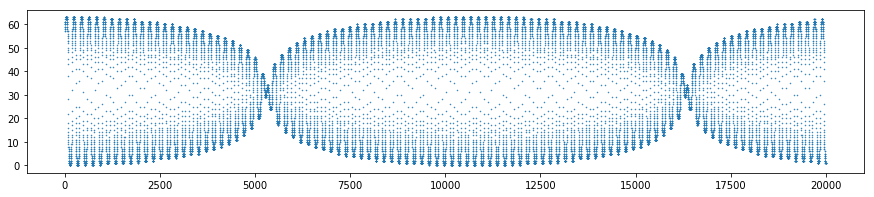

In [30]:
def sine_generator(seq_size = 6000, mu=256):
    framerate = 44100
    t = np.linspace(0,5,framerate*5)
    data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    data = data/2
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start:start+seq_size]
        ys = encode_mu_law(ys,mu)
        yield Variable(torch.from_numpy(ys[:seq_size]))
        
g = sine_generator(mu=64, seq_size=20000)
x = next(g)
plt.figure(figsize=[15,3])
plt.plot(x.data.tolist(),'.', ms=1)

## listen to the signal

In [31]:
y = x.data.numpy()
y = decode_mu_law(y, 64)
Audio(y,rate=44100)

## network training

This network tries to generate the vibrating sine wave above. 
- The audio signal is quantized to 64 discrete integers.
- 24 channels in residue outputs
- 128 channels in skip outputs
- 20 dilation layers (n_repeat=2, dilation_depth=10)

epoch 0, loss 4.158907890319824


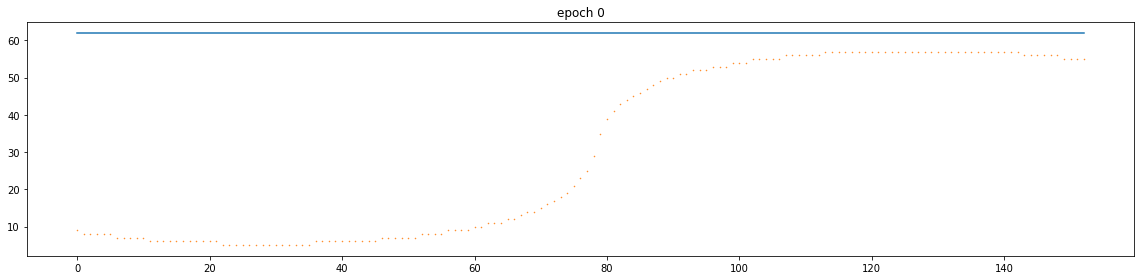

epoch 100, loss 0.328971266746521


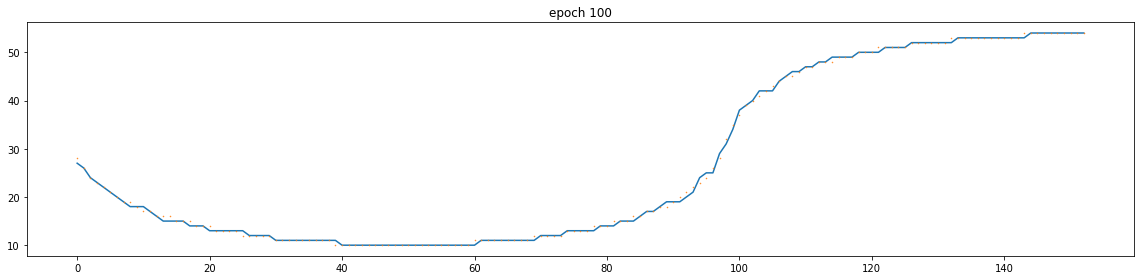

epoch 200, loss 0.20671871304512024


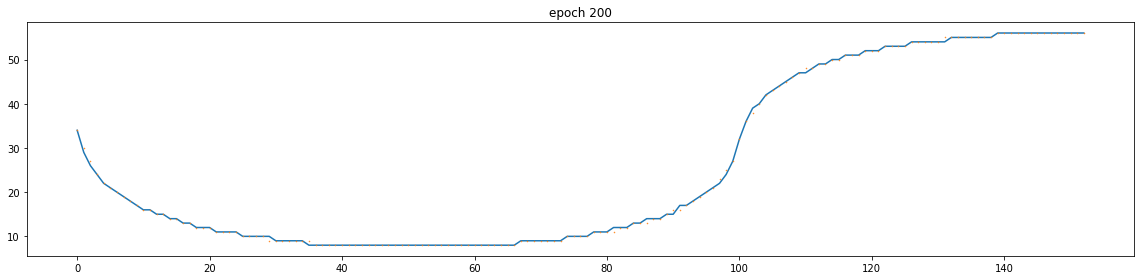

epoch 300, loss 0.1925140917301178


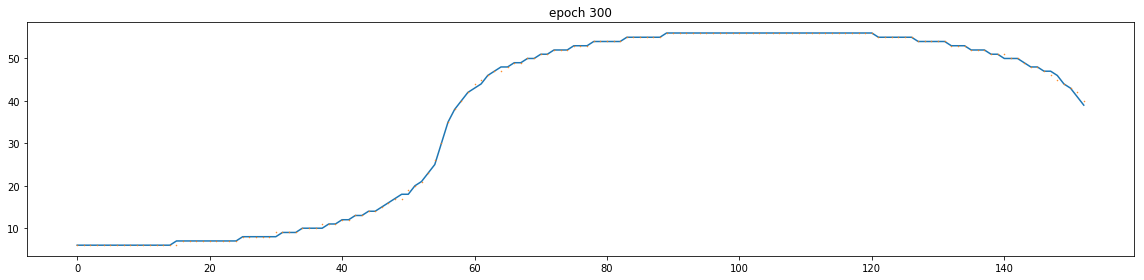

epoch 400, loss 0.1166098490357399


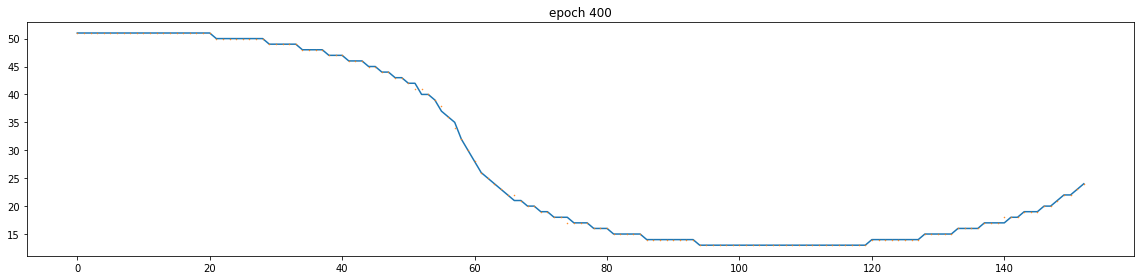

epoch 500, loss 0.10214901715517044


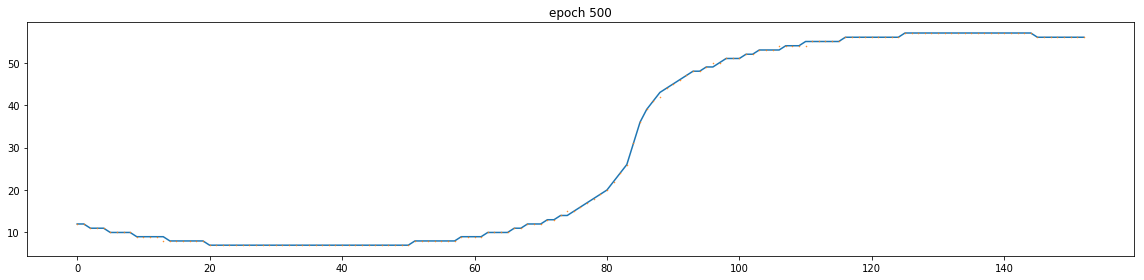

epoch 600, loss 0.08908869326114655


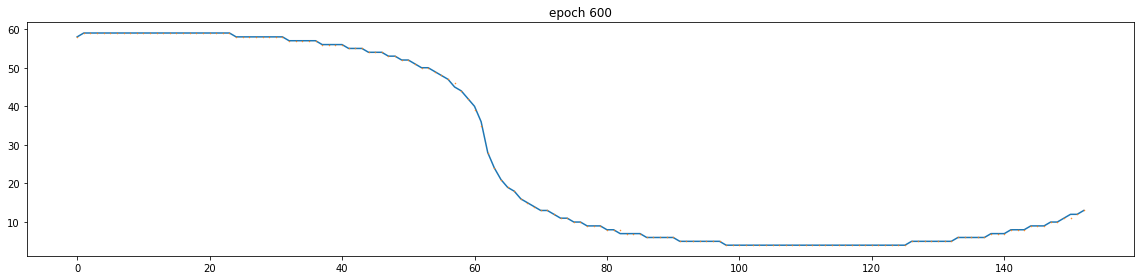

In [32]:
net = WaveNet(mu=64,n_residue=24,n_skip=128,dilation_depth=10,n_repeat=2)
net.cuda()
optimizer = optim.Adam(net.parameters(),lr=0.01)
g = sine_generator(seq_size=2200,mu=64)
batch_size = 64

loss_save = []
max_epoch = 700
for epoch in range(max_epoch):
    optimizer.zero_grad()
    loss = 0
    for _ in range(batch_size):
        batch = next(g)
        x = batch[:-1]
        logits = net(x)
        sz = logits.size(0)
        loss += nn.functional.cross_entropy(logits, batch[-sz:].cuda())
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    # monitor progress
    if epoch%100==0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        batch = next(g)
        logits = net(batch[:-1])
        _, i = logits.max(dim=1)
        plt.figure(figsize=[16,4])
        plt.plot(i.data.tolist())
        plt.plot(batch.data.tolist()[sum(net.dilations)+1:],'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()

## loss function

Text(0.5,1,'loss function')

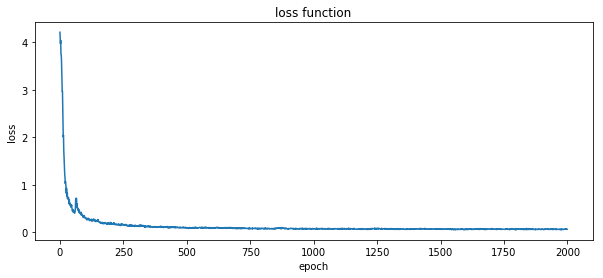

In [60]:
plt.figure(figsize=[10,4])
plt.plot(loss_save)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss function')

## data generation

In [33]:
%time y_gen = net.generate(batch, 4000)

CPU times: user 50.3 s, sys: 776 ms, total: 51 s
Wall time: 51 s


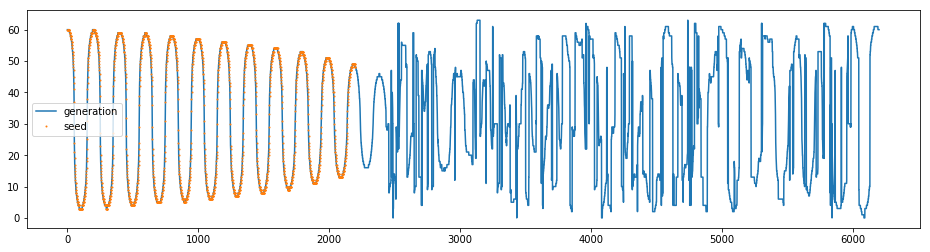

In [34]:
plt.figure(figsize=[16,4])
plt.plot(y_gen)
plt.plot(batch.data.tolist(),'.',ms=2)
plt.legend(['generation','seed'])

## listen to generated sample

In [35]:
%time y_gen = net.generate(batch, 10000)

CPU times: user 1min 59s, sys: 1.7 s, total: 2min 1s
Wall time: 2min 1s


In [36]:
y = np.array(y_gen)
y = decode_mu_law(y, 64)
Audio(y, rate=44100)